<a id="TopofBAGofMotifsTutorial_v1"></a>
<h1><font color="blue"> Getting started with Bag-of-Motifs for binary classification</font></h1>

BOM takes as input a table of regulatory region coordinates labeled with one or more cell types/states 

We present a walkthough using snATAC-seq data of whole mouse embryos resolved to 17 cell types (Pijuan-Sala et al 2020) . In this data, snATAC-seq peaks were annotated to cell types based on their differential accessibility compared to other cell types. If working with snATAC-seq data, Signac and ArchR have inbuilt tests to provide sets of marker peaks for each cell cluster which can be used as input. 

Document shortcut links:
<ul><li><a href="#BAGofMotif_Installation">Installation information</a></li>
    <li><a href="#BagOfMotif_QuickStart">Quick start</li>
    <li><a href="#Step1DataProcess">Step1 Prepare BED file</a></li>
    <li><a href="#Step2PeakFilter">Step2 Peak Filter</a></li>
    <li><a href="#Step3MotifSearching">Step3 Motif Searching</a></li>
    <li><a href="#Step4MotifCounting">Step4 Motif Counting</a></li>
    <li><a href="#Step5Predicting">Step5 Model Predicting</a></li>
    <li><a href="#Step7SHAP_interpretations">Step6 Shap interpretations</a></li>
    <li><a href="#BOM_references">References</a></li>
</ul>



---
<a id="BAGofMotif_Installation"></a>
<h3><font color="brown">Installation</font></h3>

In [1]:
# If you havn't done so already install the BagOfMotifs R package. 
# You will need to adjust you local directory for where BagOfMotifs was downloaded.

# setwd("c:/Users/d.humphreys/Documents/GitHub/BOM_package/")
# devtools::build()  # Cannot do this via jupyterlab 

install.packages("~/capsule/data/BagOfMotifs_0.0.2.tar.gz", repos = NULL, type = "source")
install.packages("cowplot")
install.packages("cvAUC")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Set paths for this vignette
working_path <- '/results/'
setwd(working_path)

# There are a number of example files in package. 
# For the purpose of this vignette we define the required files for the vignette below
extdata_path <- system.file("extdata",package="BagOfMotifs")
motifs_path  <- paste0(extdata_path,"/gimme.vertebrate.v5.0.meme")
chr_sizes <- paste0(extdata_path, '/mouse_sizes_primary_genome_tab.txt')


---
<a id="BagOfMotif_QuickStart"></a>
<h3><b><font color="red">Quickstart</font></b></h3>

Starting data is either a bed file of pre-prepared entries or a text file with at least four columns (chromosome, start, stop, cell ID).



In [3]:
# Load example DATA and convert to BED file
extdata_path <- system.file("extdata",package = "BagOfMotifs")
sampleData_filename <- paste0(extdata_path,'/Pijuan_etal_table_S6.csv.gz')
motifs_path  <- paste0(extdata_path,"/gimme.vertebrate.v5.0.meme")
chr_sizes <- paste0(extdata_path, '/mouse_sizes_primary_genome_tab.txt')

# Load pre-existing data (or replace this with your own)
bed_file <- paste0(working_path,'/mouseE8.25_peaks.bed')
textToBED(inputTextFile = sampleData_filename, outputFileName=output_file )


# Filter CREs (generates BED file for each cell type
BagOfMotifs::filterCREs(inputBedFile = input_bed, annotFile = annot, chrSizes=chr_sizes,
                        u = 1000, d = 1000, nbp= 500,
                        keep_proximal = FALSE,
                        remove_proximal = TRUE,
                        non_exonic = TRUE, out_bed="mouseE8.25_peaks_filt.bed",
                        celloutputDir =  paste0(working_path,"/mouseE8.25_bed/")
                        )

# Identify motifs 
BagOfMotifs::runFIMO(input_path = '/results/mouseE8.25_bed/', motifs_path = motifs_path, 
                  out_path = "mouseE8.25_motifs", FIMO_path = '/path/to/fimo')

# Training
BagOfMotifs::matrix_binModel(target_ct = NULL,
                             data_path = "/data/tutorial/motifs/",
                             qval_thresh = 0.5, 
                             outDir = "/results/", nthreads=4)

# Predicting
BagOfMotifs::predict_binary(motifs = "/results/Cardiomyocytes_vs_other_counts.txt",
                            xgb_model = "/results/Cardiomyocytes_vs_other.rds", 
                            training_set = "/results/Cardiomyocytes_vs_other_train.txt",
                            pred = "/results/Cardiomyocytes_vs_other_pre.txt"  # output file name
                           )

# explain and plot 
# add in command in for visualization

ERROR: Error in parse(text = x, srcfile = src): <text>:9:8: unexpected symbol
8: # Generate BED files for each cell type
9: simple command
          ^


---
<a id="Step1DataProcess"></a>
<h3><font color="brown"> Step 1 Prepare BED file of peak coordinates  </font></h3>


 

Alternatively you can provided you own data - i.e. a dataframe containing chromosome, start, end and cell type information. 

<a href="#TopofBAGofMotifsTutorial_v1">Back to top of document</a>

In [3]:

# load snATAC data
extdata_path <- system.file("extdata",package = "BagOfMotifs")
sampleData_filename <- paste0(extdata_path,'/Pijuan_etal_table_S6.csv.gz')

# Convert text file to BED file
output_file <- paste0(working_path,'/mouseE8.25_peaks.bed')
BagOfMotifs::textToBED(inputTextFile = sampleData_filename, outputFileName=output_file )


---
<a id="Step2PeakFilter"></a>
<h3><font color="brown"> Step 2_ Peak filter</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

The function "filterCREs" filters the peaks. 
Possible filter options within filterCREs include
 
- keeping only regions that are proximal to a transcription start site (TSS)
- keeping only regions located distally
- remove any regions overlapping exons
- adjust the width of the regions to ensure concistency. 


Required arguments:
- 'input_bed' : provide peak data in .bed format.
- 'annot'     : provide a genome annotation file (*.gtf).
- 'chr_sizes' : provide a genome size file.
- 'out_bed'   : provide a output filename.


**In this walkthrough**, we focus on cell-type specific distal elements so we remove the peaks located within 1kb from a TSS and the peaks overlapping exons. We also adjust the width of each element so that each peak is centered and spans 500bp. We also remove peaks that are annotated to multiple cell types as well.

A gencode mm10 mouse gene model is attached to this package and is used in the code below.


In [3]:
date() # takes ~2mins to complete

annot= paste0(extdata_path, "/Mus_musculus.GRCm38.92.gtf.gz")
# The following is the same file generated above and saved to /results/mouseE8.25_peaks.bed
input_bed <- paste0(extdata_path,'/tutorial/mouseE8.25_peaks.bed')

chr_sizes <- paste0(extdata_path, '/mouse_sizes_primary_genome_tab.txt')
BagOfMotifs::filterCREs(inputBedFile = input_bed, annotFile = annot, chrSizes=chr_sizes,
                        u = 1000, d = 1000, nbp= 500,
                        keep_proximal = FALSE,
                        remove_proximal = TRUE,
                        non_exonic = TRUE, out_bed="mouseE8.25_peaks_filt.bed",
                        celloutputDir =  paste0(working_path,"/mouseE8.25_bed/")
                        )
date()

[1] "Wed Dec  6 07:16:29 2023"

Reading CREs...


Reading genome annotation...


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK

Removing exonic regions...


Removing proximal regions to TSSs...




Reading chromosome sizes...
Adjusting CRE length...


Saving CREs...


Preparing output directories and files so that everything is set for motif searching


The following cell(s) represent less than 1% of all cells.
This is the predefined cutoff as defined by parameter minCellPercent.
Outputs for following cell(s) will therefore not be generated:
Notochord
Ubiquitous


The following files have been prepared: 
Pharyngeal_mesoderm.bed
Forebrain.bed
Gut.bed
Paraxial_mesoderm.bed
Spinal_cord.bed
Somitic_mesoderm.bed
Endothelium.bed
Cardiomyocytes.bed
Mid_Hindbrain.bed
Neural_crest.bed
Erythroid.bed
NMP.bed
Mesenchyme.bed
Surface_ectoderm.bed
Mixed_mesoderm.bed
Allantois.bed
ExE_endoderm.bed



[1] "Wed Dec  6 07:17:24 2023"

---
<a id="Step3MotifSearching"></a>
<h3><font color="brown"> Step_3 Motif Searching</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

**Note ** this step  requires that your computer has an installation of the **MEME suite**. The vertebrate motifs from the [database GIMME Motifs](https://github.com/vanheeringen-lab/gimmemotifs) [2] are used in the tutorial. 

This step identifies transcription factor (TF) binding motifs within the CRE using FIMO from the MEME suite.



There are two options to annotate peaks.
In general, Fimo is fast. Files that have ~1000 peaks will take approximately 5 minutes to compute. But if you have more regions consider using the command line

1. BagOfMotifs R package function: **runFIMO**. 









In [ ]:
# This is an example of how to use runFIMO function
motifs_path = paste0(extdata_path, "/gimme.vertebrate.v5.0.meme")

BagOfMotifs::runFIMO(input_path = '/results/mouseE8.25_bed/', motifs_path = motifs_path, 
                   out_path = "mouseE8.25_motifs", FIMO_path = '/path/to/fimo')

2. Run fimo using gnu parallel on the command line

    Here is an example of how to run FIMO using bash parallel via bash command line 

    cd directory_containing_fastaFiles <br>

    mkdir mouseE8.25_motifs<br>

    ls *.fasta | parallel fimo --thresh 0.001 --o {.} gimme.vertebrate.v5.0.meme mouseE8.25_motifs/{}



---
<a id="Step4MotifCounting"></a>
<h3><font color="brown"> Step_4 Motif counting</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>



In this step, the motif counts matrix will be prepared for binary classification, by running <code>matrix_binModel</code> function.

Required arguments for this function include

- 'target_ct'   : Target cell type condition
- 'data_path'   : Path to directoy containing motifs
- 'qval_thresh' : q value threshold
- 'outDir'      : Name of directory to save output files. Output files will be named cellType_vs_Others

<a href="#TopofBAGofMotifsTutorial_v1">Back to top of document</a>

In [5]:
# prepare counts for binary classifications
# Leaving target_ct as NULL means all cell types will be processed
date() # takes ~2-3 mins to run for all celltypes 
BagOfMotifs::matrix_binModel(target_ct = NULL,
                             data_path = "/data/tutorial/motifs/",
                             qval_thresh = 0.5, 
                             outDir = "/results/", nthreads=4)
date()

[1] "Wed Dec  6 05:59:25 2023"

Reading input data from /data/tutorial/motifs/.
There are 17 directories found.

Writing output

Processing all cell types

training....

Preparing training for Allantois

Preparing training for Cardiomyocytes

Preparing training for Endothelium

Preparing training for Erythroid

Preparing training for ExE_endoderm

Preparing training for Forebrain

Preparing training for Gut

Preparing training for Mesenchyme

Preparing training for Mid_Hindbrain

Preparing training for Mixed_mesoderm

Preparing training for Neural_crest

Preparing training for NMP

Preparing training for Paraxial_mesoderm

Preparing training for Pharyngeal_mesoderm

Preparing training for Somitic_mesoderm

Preparing training for Spinal_cord

Preparing training for Surface_ectoderm

Complete



[1] "Wed Dec  6 06:01:10 2023"

In the output matrix, every CRE will be represented by a row and columns represent different motifs. The last 2 columns contain the cell type annotation, "celltype" contains the actual cell type name and "binary_celltype" contains the cell tipy coded as a binary, 1 represents cardiomyocyte CRE and 0 represents background CRE.


In [6]:
counts <- read.table(file = "/results/Cardiomyocytes_vs_Others.txt", header = T, 
                     stringsAsFactors = F, sep = '\t')
head(counts[,c(head(colnames(counts)), tail(colnames(counts), 2))])

,GM.5.0.AP.2.0001,GM.5.0.AP.2.0002,GM.5.0.AP.2.0003,GM.5.0.AP.2.0004,GM.5.0.AP.2.0005,GM.5.0.AP.2.0006,celltype,binary_celltype
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
1:10123919-10124419,0,0,0,0,0,0,Mixed_mesoderm,0
1:116125733-116126233,0,0,0,0,0,0,NMP,0
1:119457210-119457710,0,0,1,0,1,0,Somitic_mesoderm,0
1:121371389-121371889,0,0,0,0,0,0,Pharyngeal_mesoderm,0
1:127731124-127731624,0,0,0,0,0,0,Allantois,0
1:13240076-13240576,0,0,0,0,0,0,Mesenchyme,0


---
<a id="Step5Predicting"></a>
<h3><font color="brown"> Step_5 Predicting</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

Now, we use trained model to predict on the test set, by using **"predict_binary"** function. 




Reading classification model...

Saving XGBoost model in .bin format...

Best tree: 33 


Reading motif counts matrix...

Saving training set to /results//Cardiomyocytes_vs_other_train.txt ...

Preparing ROC plots

Loading required package: cvAUC

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: ggplot2

Setting levels: control = 0, case = 1



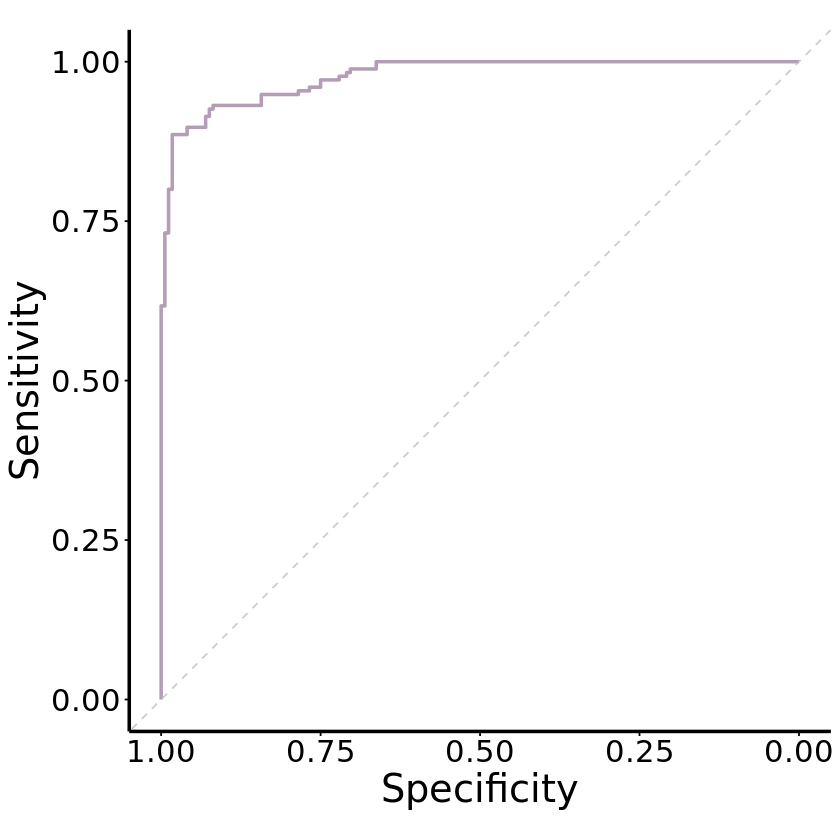

In [7]:
BagOfMotifs::predict_binary(motifs = paste0(working_path,"/Cardiomyocytes_vs_Others.txt"),
                            xgb_model = paste0(working_path,"/Cardiomyocytes_vs_Others.rds"), 
                            # Following files are generated from this function
                            training_set = paste0(working_path,"/Cardiomyocytes_vs_other_train.txt")
                           )

In [8]:
BagOfMotifs::predict_binary_multi(inputMotif_dir = working_path,
                                  inputXGB_dir = working_path, 
                                  outputTrain_dir = working_path, outputFile = "output.pdf")

Preparing Allantois_vs_Others predict binary output

Preparing Cardiomyocytes_vs_Others predict binary output

Preparing Endothelium_vs_Others predict binary output

Preparing Erythroid_vs_Others predict binary output

Preparing ExE_endoderm_vs_Others predict binary output

Preparing Forebrain_vs_Others predict binary output

Preparing Gut_vs_Others predict binary output

Preparing Mesenchyme_vs_Others predict binary output

Preparing Mid_Hindbrain_vs_Others predict binary output

Preparing Mixed_mesoderm_vs_Others predict binary output

Preparing Neural_crest_vs_Others predict binary output

Preparing NMP_vs_Others predict binary output

Preparing Paraxial_mesoderm_vs_Others predict binary output

Preparing Pharyngeal_mesoderm_vs_Others predict binary output

Preparing Somitic_mesoderm_vs_Others predict binary output

Preparing Spinal_cord_vs_Others predict binary output

Preparing Surface_ectoderm_vs_Others predict binary output

Loading required package: cowplot



png 
  2

The output file contains 3 columns. The first column indicates the true class of the CRE, 1 representing cardiomyocyte CRE and 0 representing background CRE. The second column represents the predicted classes coded as a binary with a threshold of > 0.5. The last column represents the predicted probability by the model. We can use these values to calculate some metrics of performance. 

Output values for the area under the Receiver Operating Characteristic (ROC) curve (auROC), area under the precision/recall curve (auPR), accuracy, F1 score, recall and precision and provided for all cell types. ROC curves and a precision/recall curves are also provided in the output.


---
<a id="Step7SHAP_interpretations"></a>
<h3><font color="brown"> Step_6 SHAP interpretations </font></h3>

From the models we now calculate the SHAP values and prepare plots which will inform which features (motifs) are significant for each cell type.

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>



In [19]:
# Load model 
xgb_model <- readRDS(paste0(working_path,"/Cardiomyocytes_vs_Others.rds"))
# Load training set
training_set = paste0(working_path,"/Cardiomyocytes_vs_Others.txt")
ts <- read.table(training_set,header = TRUE)


# make sure column names match between training set and xgb
cols <- (intersect(colnames(ts), xgb_model$feature_names))
ts <- ts[,cols]  

# Create SHAP values
shp <- shapviz::shapviz(object = xgb_model, data.matrix(ts))

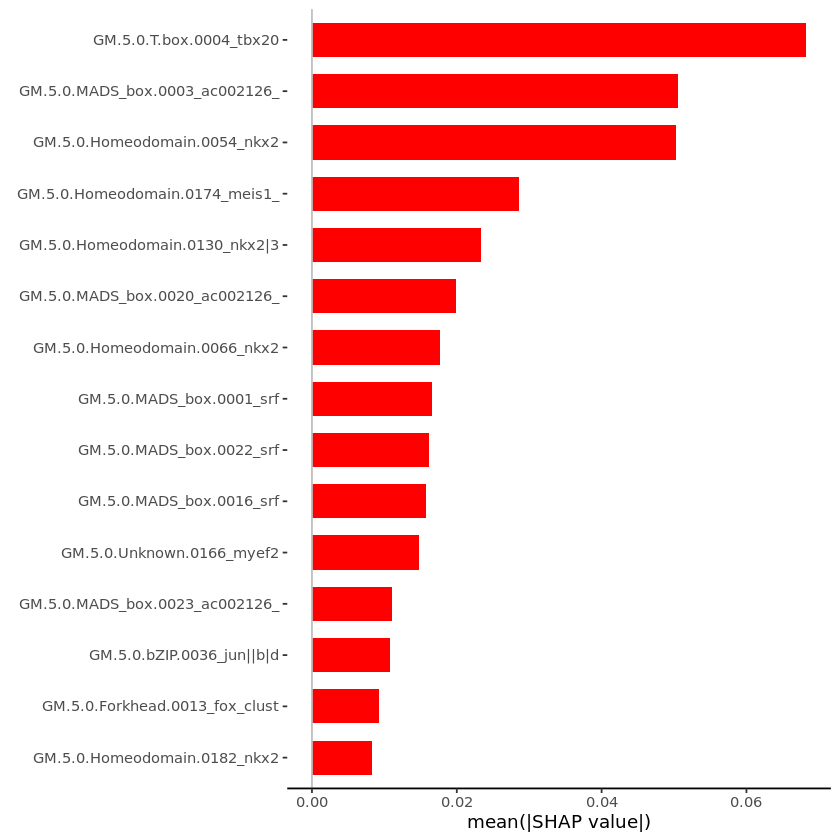

In [21]:
# Load summary annotation table which is provided in BagOfMotifs package. 
extdata_path <- system.file("extdata",package = "BagOfMotifs")
gimme.fn <- paste0(extdata_path,"/gimme.vertebrate.v5.0.annot_summarized_shorten.txt.gz")
gimme_annot <- read.table(gimme.fn,header = TRUE, fill=TRUE)

# If we provide annotDat then the Y-axis will populate with both the motif ID plus the transcription factor name
# Note the default is to truncate the Y-axis labels to 30 characters as some names interfere with plot sizes. 
# This can be changed with parameter annotLength.
# If parameter annotDat is not provided then only the generic motif name is used for labels
BagOfMotifs::shapPlots(shp, plotType="bar", annotDat = gimme_annot) 


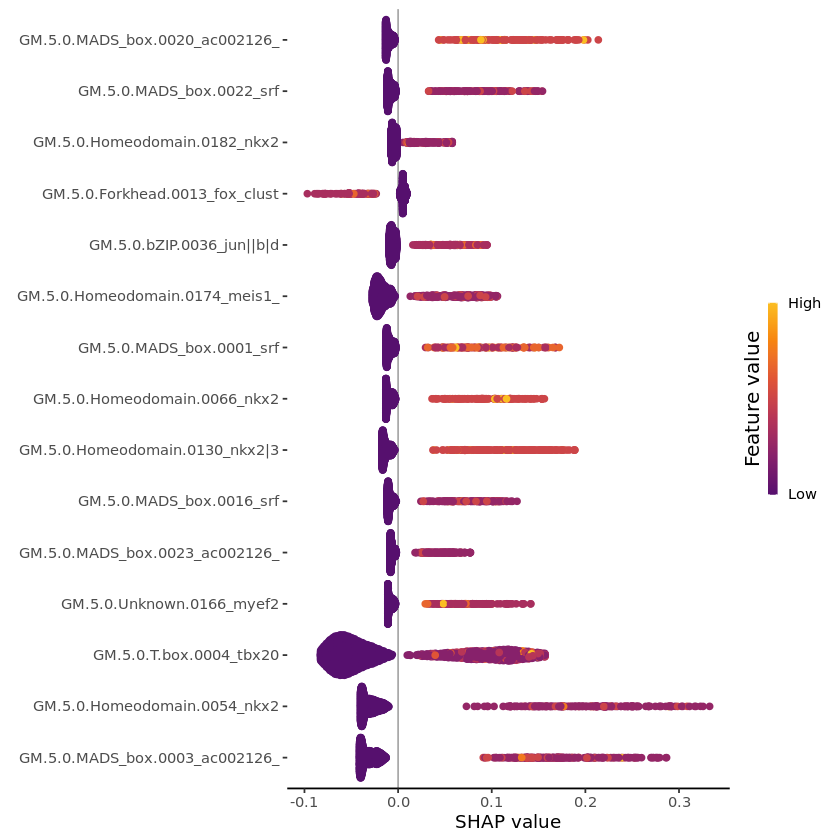

In [22]:
BagOfMotifs::shapPlots(shp, plotType="beeswarm", annotDat = gimme_annot) 

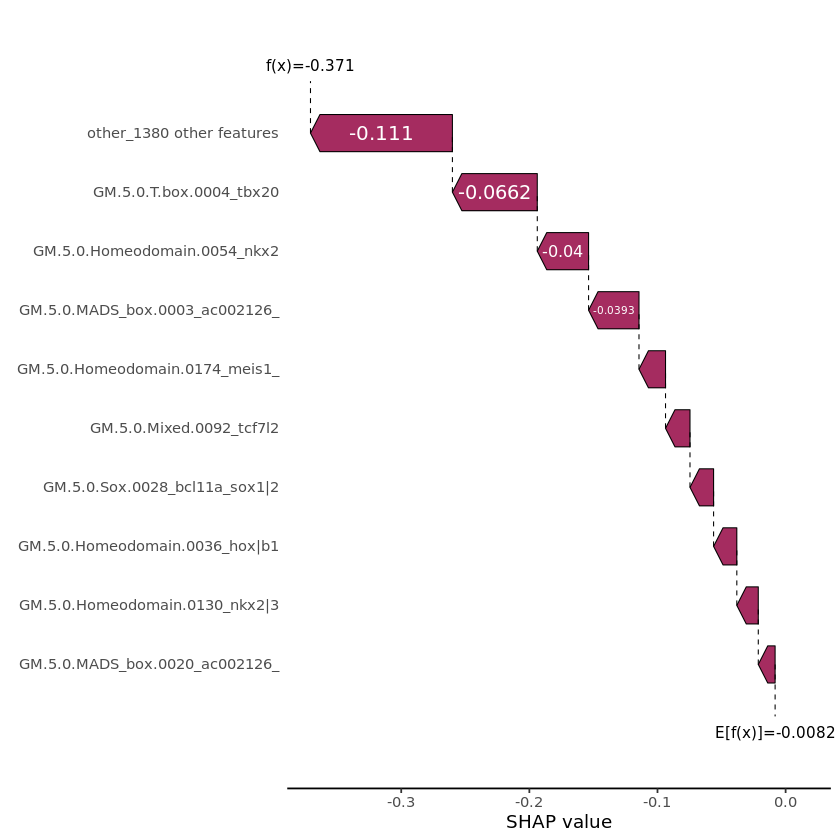

In [23]:
BagOfMotifs::shapPlots(shp, plotType="waterfall", annotDat = gimme_annot) 


---
<a id="BOM_references"></a>
<h3><font color="brown"> References</font></h3>

<a href="#TopofBAGofMotifsTutorial_v1">back to top of document</a>

1. Pijuan-Sala, B., Wilson, N. K., Xia, J., Hou, X., Hannah, R. L., Kinston, S., ... & Göttgens, B. (2020). Single-cell chromatin accessibility maps reveal regulatory programs driving early mouse organogenesis. Nature cell biology, 22(4), 487-497.
2. Bruse, N., & Heeringen, S. J. V. (2018). GimmeMotifs: an analysis framework for transcription factor motif analysis. BioRxiv, 474403.
3. Charles E. Grant, Timothy L. Bailey and William Stafford Noble, "FIMO: Scanning for occurrences of a given motif", Bioinformatics 27(7):1017-1018, 2011. [full text]
4. Quinlan, A. R., & Hall, I. M. (2010). BEDTools: a flexible suite of utilities for comparing genomic features. Bioinformatics, 26(6), 841-842.
5. Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., ... & Lee, S. I. (2020). From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), 56-67.